In [ ]:
# download data: https://drive.google.com/file/d/1U6WD6V563igKFUedzVT_hCvFeY2-tFE_/view?usp=sharing

# Fine-tuning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#PATH = '/content/gdrive/My Drive/data/cats_and_dogs_small/'
PATH = 'cats_and_dogs_small/'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 128
IMG_SIZE = (160, 160)
BUFFER_SIZE = BATCH_SIZE*5

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


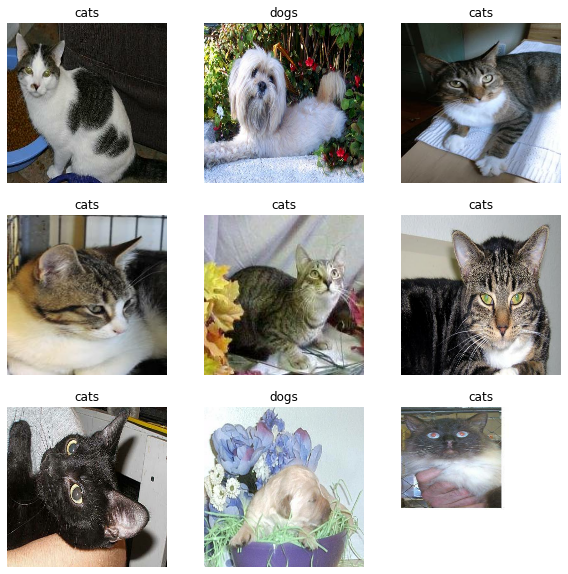

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
train_dataset = train_dataset.prefetch(buffer_size=BUFFER_SIZE)
validation_dataset = validation_dataset.prefetch(buffer_size=BUFFER_SIZE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

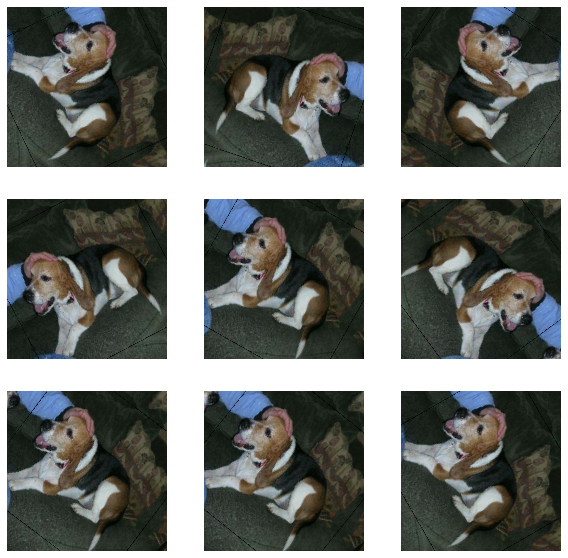

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [9]:
print(IMG_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

(160, 160)
(160, 160, 3)


In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 5, 5, 512)


In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 512)


In [13]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 1)


In [14]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [15]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [16]:
# Fine-tune from this layer onwards
fine_tune_at = 14

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [17]:
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)              

In [19]:
len(model.trainable_variables)

8

In [20]:
history_fine = model.fit(train_dataset,
                         epochs=150,
                         validation_data=validation_dataset)

Epoch 1/150
16/16 [==============================] - 5s 339ms/step - loss: 2.1643 - accuracy: 0.6230 - val_loss: 0.6694 - val_accuracy: 0.8180
Epoch 2/150
16/16 [==============================] - 3s 215ms/step - loss: 0.6697 - accuracy: 0.7945 - val_loss: 0.3234 - val_accuracy: 0.8980
Epoch 3/150
16/16 [==============================] - 4s 224ms/step - loss: 0.4033 - accuracy: 0.8480 - val_loss: 0.2596 - val_accuracy: 0.9190
Epoch 4/150
16/16 [==============================] - 3s 216ms/step - loss: 0.2959 - accuracy: 0.8800 - val_loss: 0.1745 - val_accuracy: 0.9450
Epoch 5/150
16/16 [==============================] - 3s 216ms/step - loss: 0.2248 - accuracy: 0.9155 - val_loss: 0.1409 - val_accuracy: 0.9540
Epoch 6/150
16/16 [==============================] - 3s 215ms/step - loss: 0.2004 - accuracy: 0.9185 - val_loss: 0.1376 - val_accuracy: 0.9570
Epoch 7/150
16/16 [==============================] - 3s 214ms/step - loss: 0.1721 - accuracy: 0.9400 - val_loss: 0.1286 - val_accuracy: 0.9620

Epoch 58/150
16/16 [==============================] - 3s 218ms/step - loss: 0.0143 - accuracy: 0.9950 - val_loss: 0.0869 - val_accuracy: 0.9730
Epoch 59/150
16/16 [==============================] - 3s 217ms/step - loss: 0.0063 - accuracy: 0.9980 - val_loss: 0.1044 - val_accuracy: 0.9720
Epoch 60/150
16/16 [==============================] - 3s 218ms/step - loss: 0.0117 - accuracy: 0.9960 - val_loss: 0.0886 - val_accuracy: 0.9740
Epoch 61/150
16/16 [==============================] - 3s 217ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.1320 - val_accuracy: 0.9680
Epoch 62/150
16/16 [==============================] - 4s 220ms/step - loss: 0.0115 - accuracy: 0.9945 - val_loss: 0.0954 - val_accuracy: 0.9730
Epoch 63/150
16/16 [==============================] - 3s 216ms/step - loss: 0.0069 - accuracy: 0.9970 - val_loss: 0.0853 - val_accuracy: 0.9710
Epoch 64/150
16/16 [==============================] - 3s 216ms/step - loss: 0.0090 - accuracy: 0.9975 - val_loss: 0.0958 - val_accuracy:

Epoch 115/150
16/16 [==============================] - 4s 220ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0965 - val_accuracy: 0.9760
Epoch 116/150
16/16 [==============================] - 3s 215ms/step - loss: 0.0030 - accuracy: 0.9985 - val_loss: 0.0914 - val_accuracy: 0.9730
Epoch 117/150
16/16 [==============================] - 3s 217ms/step - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.1118 - val_accuracy: 0.9730
Epoch 118/150
16/16 [==============================] - 3s 218ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.1015 - val_accuracy: 0.9750
Epoch 119/150
16/16 [==============================] - 4s 219ms/step - loss: 0.0034 - accuracy: 0.9980 - val_loss: 0.0852 - val_accuracy: 0.9760
Epoch 120/150
16/16 [==============================] - 4s 220ms/step - loss: 9.5157e-04 - accuracy: 1.0000 - val_loss: 0.0901 - val_accuracy: 0.9780
Epoch 121/150
16/16 [==============================] - 3s 218ms/step - loss: 0.0028 - accuracy: 0.9985 - val_loss: 0.0860 - va

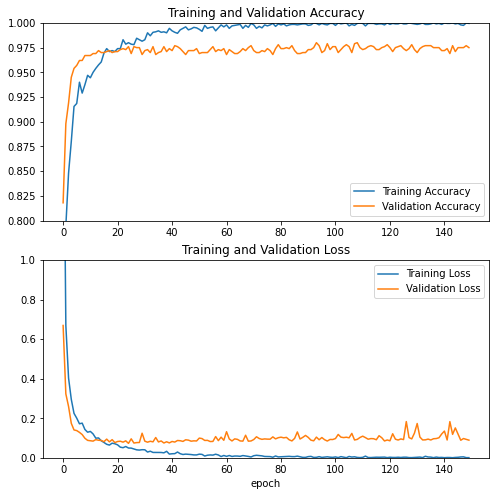

In [21]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
